# A primer on `juliet` for TESS analyses --- 5 minutes version
------------------------------------------------------------
**Author**: Néstor Espinoza (nespinoza@stsci.edu) | **Last update**: September 6, 2020

## 1. Preface

This tutorial was made as part of the `online.tess.science` collaboration & co-working event (https://online.tess.science/). Given the event is focused on the analysis of TESS data, here we give a brief overview of what the `juliet` library has to offer for researchers interested in analyzing lightcurves from the mission. The intended audience of this primer are folks who have a basic understanding of transit lightcurves (what they are, how they are measured), of [bayes theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem#:~:text=In%20probability%20theory%20and%20statistics,be%20related%20to%20the%20event.) (i.e., they know what "a prior" is) and how TESS operates. So if you know that, you are good to go! 

Before starting the tutorial, make sure you have installed `juliet` in your system. To do that, open an terminal and simply do `pip install juliet`.

Assuming you have installed `juliet`, then, **let's import the library together with other useful libraries for this notebook**:

In [1]:
# Import the juliet library:
import juliet

# Import corner for corner plots:
import corner

# Import numpy for general operations, matplotlib for plots:
import numpy as np
import matplotlib.pyplot as plt
# Some tools to include insets:
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# Seaborn for pretty plots:
import seaborn as sns
sns.set_style('ticks')

## 2. What is `juliet`?

`juliet` (http://juliet.readthedocs.io/) is a library for the analysis and modelling of transiting, non-transiting and variable stars which uses [Nested Sampling algorithms](https://en.wikipedia.org/wiki/Nested_sampling_algorithm) (for a very nice introduction to Nested Sampling algorithms --- and the `dynesty` library, in particular, a library `juliet` uses to perform its sampling, see [this great talk by Josh Speagle](https://www.youtube.com/watch?v=CfyzvoqA9rw&feature=youtu.be), lead developer of `dynesty`) in order to fit lightcurves and radial-velocities (RVs). In simple words: if you have photometry at hand (or, for TESS, if you only have the TIC ID --- as will be shown below, `juliet` can actually retrieve TESS data directly from the MAST archive!), RVs or both, `juliet` will make it as easy as possible for you to fit the data and extract the properties that data can give you, including errorbars and even _distributions_ of those parameters given the data.

The library was initially thought to analyze transit lightcurves and RVs for transiting exoplanets, but `juliet` users have been using the tool for [RV studies](https://ui.adsabs.harvard.edu/abs/2020A%26A...640A..50B/abstract) and [variability studies](https://ui.adsabs.harvard.edu/abs/2020A%26A...636A.119S/abstract) (both in RVs and photometry) --- the possibilites are endless!

## 3. Retrieving TESS lightcurves with `juliet`

After this quick intro to `juliet`, let's jump right into what the library can offer for TESS enthusiasts. As you might have guessed from the title of this section, `juliet` does not only let you fit TESS photometry --- but it also has some nice tools to _retrieve_ TESS photometry directly from the [MAST archive](https://archive.stsci.edu/)! Let's extract the data for example of one of my favorite exoplanets: WASP-19b:

In [2]:
times, fluxes, fluxes_errors = juliet.utils.get_all_TESS_data('WASP-19b')

This one-liner simply goes to the MAST archive, does a query on the target name and retrieves the lightcurves on all the sectors where there is 2-minute cadence data. By default, the `get_all_TESS_data` call returns the PDC lightcurves (i.e., the ones corrected for instrumental systematics with the Pre-Data Conditioning pipeline), but the function has options to retrieve the uncorrected data as well (not shown). 

The function returns a dictionary with the times (`times`), fluxes (`fluxes`) and errors (`fluxes_errors`) of each sector. So --- what sector has 2-minute cadence data for WASP-19b? 

In [3]:
print(times.keys())

dict_keys(['TESS9'])


Only on Sector 9, it seems. Let's plot this data to see how it looks like:

Text(0, 0.5, 'Relative flux')

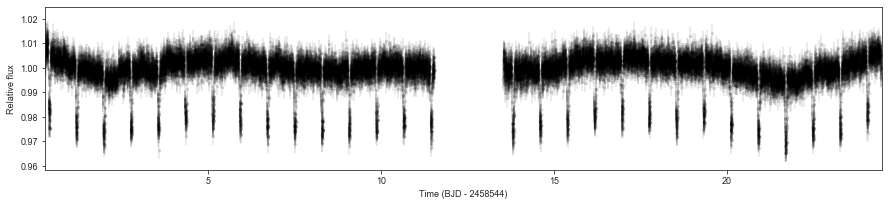

In [4]:
fig, ax = plt.subplots(figsize=(15,3))
# Find day of first TESS observation in Sector 9:
first_day = int(np.min(times['TESS9']))

# Plot entire lightcurve:
ax.errorbar(times['TESS9'] - first_day, fluxes['TESS9'], yerr = fluxes_errors['TESS9'],fmt='.', \
             color='black', alpha = 0.1)
ax.set_xlim(np.min(times['TESS9'] - first_day),np.max(times['TESS9'] - first_day))
ax.set_xlabel('Time (BJD - {0:})'.format(first_day))
ax.set_ylabel('Relative flux')

All right! This looks nice. There seems to be some variability going on, as well as several transits of the exoplanet. Note the gap in the middle? Those are data downlinks from TESS to the Earth; no data was taken at those times. 

With this lightcurve at hand, let's jump into analyzing it in detail in the next section.

## 4. Modelling variability through Gaussian Processes with `juliet`

In theory, with `juliet` you can actually fit the whole lightcurve (variability included) in one go. However, to make this tutorial incremental in terms of complexity, let's first take care of the variability with `juliet`, remove that from the lightcurve, and then fit the transit (of course, also with `juliet`!).

### 4.1 Selecting out-of-transit datapoints
To "remove" and model the variability, we first need to mask the in-transit points, so we only model the out-of-transit data. For WASP-19b, this is relatively easy, because we know its [period](http://exoplanet.eu/catalog/WASP-19_b/) ($P=0.7888$ days) and its [time-of-transit center](https://arxiv.org/abs/2001.11112) ($T_0 = 2458555.4547$). If you substract this time-of-transit to the times, and divide this by the period, each transit center will be an integer number. If we then take only the non-integer part of that number, we are left with what we usually refer to as the _phases_. `juliet` has an utility function (`juliet.utils.get_phases`) that returns these phases for you in a one-liner; let's use that to plot the transit in phase-space:

In [5]:
phases = juliet.utils.get_phases(times['TESS9'], 0.7888, 2458555.4547)

Let's plot the data in phase-space (the "phased" lightcurve):

(<mpl_toolkits.axes_grid1.inset_locator.BboxPatch at 0x7fa301c24128>,
 <mpl_toolkits.axes_grid1.inset_locator.BboxConnector at 0x7fa301c248d0>)

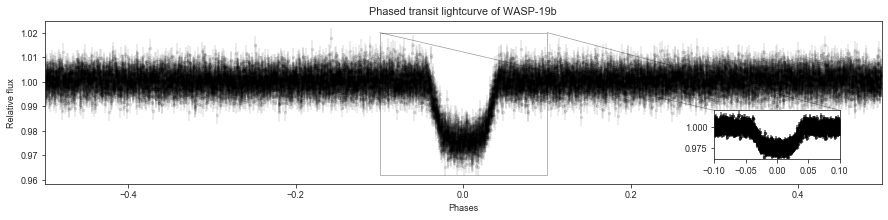

In [6]:
fig, ax = plt.subplots(figsize=(15,3))
# Plot main plot:
ax.errorbar(phases, fluxes['TESS9'], yerr = fluxes_errors['TESS9'],fmt='.', \
             color='black', alpha = 0.1)
ax.set_xlim(-0.5,0.5)
ax.set_title('Phased transit lightcurve of WASP-19b')
ax.set_xlabel('Phases')
ax.set_ylabel('Relative flux')
# Plot inset:
axins = ax.inset_axes([0.8, 0.15, 0.15, 0.3])
x1, x2, y1, y2 = -0.1,0.1, 0.962, 1.02
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.errorbar(phases, fluxes['TESS9'], yerr = fluxes_errors['TESS9'],fmt='.', \
             color='black', alpha = 0.6)
mark_inset(ax, axins, loc1=1, loc2=2, linewidth=0.7, fc="None", ec='k', alpha=0.4, clip_on=True, zorder=3)

That looks pretty good! As can be seen, it is easy to select only out-of-transit points in phase-space: it suffices to select datapoints whose phases are larger than about 0.05. Let's do that, create new dictionaries with the out-of-transit data, and see if we succeeded with a plot:

Text(0, 0.5, 'Relative flux')

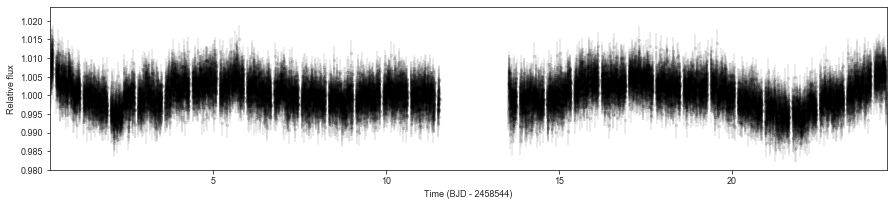

In [7]:
# Indexes of out-of-transit (oot) datapoints:
idx_oot = np.where(np.abs(phases)>0.05)[0]

oot_times, oot_fluxes, oot_fluxes_errors = {}, {}, {}
oot_times['TESS9'], oot_fluxes['TESS9'], oot_fluxes_errors['TESS9'] = times['TESS9'][idx_oot],\
                                                                      fluxes['TESS9'][idx_oot],\
                                                                      fluxes_errors['TESS9'][idx_oot]

# Plot time-series of those datapoints only:
fig, ax = plt.subplots(figsize=(15,3))
# Find day of first TESS observation in Sector 9:
first_day = int(np.min(times['TESS9']))

# Plot entire lightcurve:
ax.errorbar(times['TESS9'][idx_oot] - first_day, fluxes['TESS9'][idx_oot], yerr = fluxes_errors['TESS9'][idx_oot],fmt='.', \
             color='black', alpha = 0.1)
ax.set_xlim(np.min(times['TESS9'] - first_day),np.max(times['TESS9'] - first_day))
ax.set_xlabel('Time (BJD - {0:})'.format(first_day))
ax.set_ylabel('Relative flux')

Success! Let's now fit this with a Gaussian Process (GP).

### 4.2 Fitting a GP with `juliet`

Now that we have the out-of-transit data, let's use `juliet` to fit this variability. Fitting lightcurves with `juliet` consists, in general, of three steps: (1) **defining the priors**, (2) **loading the dataset** and (3) **peforming the fit**. Let's go through each of those steps below.

**To define the priors** in `juliet`, there are two options. One can write them in a text file and pass the filename to `juliet` ([see this example](https://juliet.readthedocs.io/en/latest/user/quicktest.html#a-first-fit-to-data-with-juliet)), or one can fill a dictionary (which we will call `priors` below) that holds this information. The easiest way of doing the latter is as follows:

In [8]:
# Set the prior paramenters names, distributions and ranges:
params =  ['mdilution_TESS9', 'mflux_TESS9', 'sigma_w_TESS9', 'GP_sigma_TESS9', 'GP_rho_TESS9']
dists =   ['fixed', 'normal', 'loguniform', 'loguniform', 'loguniform', 'loguniform', 'loguniform']
hyperps = [1., [0.,0.1], [0.1, 1e4], [0.1, 1e5], [1e-2,30]]

# Join the priors:
priors = juliet.generate_priors(params,dists,hyperps)
print(priors)

{'mdilution_TESS9': {'distribution': 'fixed', 'hyperparameters': 1.0}, 'mflux_TESS9': {'distribution': 'normal', 'hyperparameters': [0.0, 0.1]}, 'sigma_w_TESS9': {'distribution': 'loguniform', 'hyperparameters': [0.1, 10000.0]}, 'GP_sigma_TESS9': {'distribution': 'loguniform', 'hyperparameters': [0.1, 100000.0]}, 'GP_rho_TESS9': {'distribution': 'loguniform', 'hyperparameters': [0.01, 30]}}


As can be seen, each key of the `priors` dictionary is as parameter name, and each of those are dictionaries themselves containing the prior `distribution` of each parameter, and their `hyperparameters`. 

Above, for instance, we are defining the dilution factor `mdilution_TESS9` as fixed, and with a value equal to 1 (always do this if you don't suspect any second-light contamination in your lightcurve). Similarly, `mflux_TESS9` (where `1+mflux_TESS9` is the out-of-transit flux) has a `normal` distribution with mean `0` and standard-deviation `0.1`. The rest of the parameters define our systematics/statistical model --- `sigma_w_TESS9` is a "jitter" term, in case we underestimated the errorbars, and has a log-uniform prior from 0.1 to $10^4$ ppm. `GP_sigma_TESS9` defines the amplitude of the GP, and also has a log-uniform distribution from 0.1 to $10^5$ ppm. Finally, `GP_rho_TESS9` is a key parameter --- it defines both which GP we want to fit (in this case, a Mat\`ern kernel) and the time-scale of the proces. In this case, between about 14 minutes up to 30 days (for more details into other possible GP models, check out the [`juliet` documentation](https://juliet.readthedocs.io/en/latest/user/priorsnparameters.html#exoplanets-with-juliet-pt-iii-linear-models-gaussian-processes)).

Having defined the prior, now we **load the data and these priors to `juliet`** as follows:

In [9]:
dataset = juliet.load(priors=priors, t_lc = oot_times, y_lc = oot_fluxes, \
                      yerr_lc = oot_fluxes_errors, GP_regressors_lc = oot_times, \
                      out_folder = 'wasp19_GPfit')

Here, note we have passed not only the priors and the data, but also the regressors to use in our GP (the times, in our case). We have also passed an `out_folder` here, which defines an output folder where the results will be stored. This is optional, of course. Now, finally, we can simply peform the fit to the `dataset` as follows:

In [10]:
results = dataset.fit(n_live_points=300)

Let's evaluate this fit, but not only in our out-of-transit times --- let's evaluate the model in _all_ the times:

In [11]:
GP_model = results.lc.evaluate('TESS9', t = times['TESS9'], GPregressors = times['TESS9'])

And let's plot this along with our data:

Text(0, 0.5, 'Relative flux')

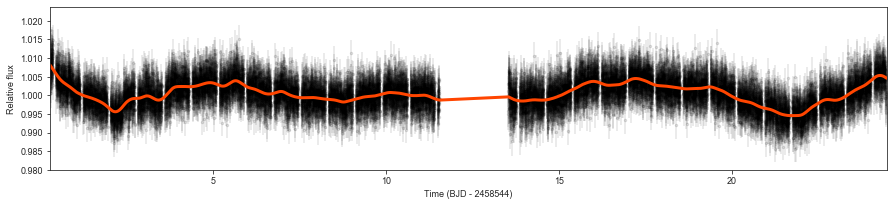

In [12]:
# Plot time-series of those datapoints only:
fig, ax = plt.subplots(figsize=(15,3))
# Find day of first TESS observation in Sector 9:
first_day = int(np.min(times['TESS9']))

# Plot entire lightcurve:
ax.errorbar(times['TESS9'][idx_oot] - first_day, fluxes['TESS9'][idx_oot], yerr = fluxes_errors['TESS9'][idx_oot],fmt='.', \
             color='black', alpha = 0.1,zorder=1)
ax.plot(times['TESS9'] - first_day, GP_model, color='orangered', lw=3,zorder=2)
ax.set_xlim(np.min(times['TESS9'] - first_day),np.max(times['TESS9'] - first_day))
ax.set_xlabel('Time (BJD - {0:})'.format(first_day))
ax.set_ylabel('Relative flux')

That looks pretty nice! Let's use this model to detrend our original data, and plot the detrended data:

Text(0, 0.5, 'Relative flux')

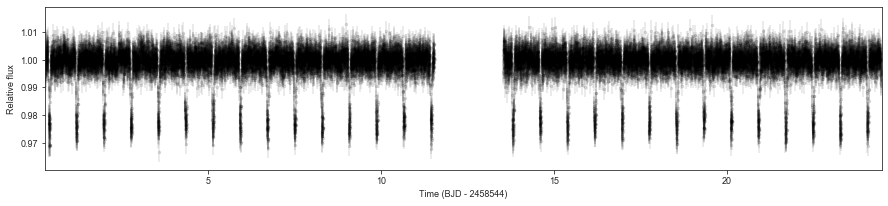

In [13]:
# Save detrended data:
detrended_fluxes, detrended_fluxes_errors = {}, {}
detrended_fluxes['TESS9'], detrended_fluxes_errors['TESS9'] = fluxes['TESS9']/GP_model, \
                                                              fluxes_errors['TESS9']/GP_model

# Plot it:
fig, ax = plt.subplots(figsize=(15,3))
# Find day of first TESS observation in Sector 9:
first_day = int(np.min(times['TESS9']))

# Plot entire lightcurve:
ax.errorbar(times['TESS9'] - first_day, detrended_fluxes['TESS9'], yerr = detrended_fluxes_errors['TESS9'],fmt='.', \
             color='black', alpha = 0.1)
ax.set_xlim(np.min(times['TESS9'] - first_day),np.max(times['TESS9'] - first_day))
ax.set_xlabel('Time (BJD - {0:})'.format(first_day))
ax.set_ylabel('Relative flux')

That looks pretty good! Let's fit those transits now.

## 5. Modelling transits with `juliet`

Now that we have a detrended lightcurve to play with, let's fit the transits. Once again, we first **define the priors**:

In [14]:
# Name of the parameters to be fit:
params = ['P_p1','t0_p1','r1_p1','r2_p1','q1_TESS9','q2_TESS9','ecc_p1','omega_p1',\
              'rho', 'mdilution_TESS9', 'mflux_TESS9', 'sigma_w_TESS9']

# Distribution for each of the parameters:
dists = ['normal','normal','uniform','uniform','uniform','uniform','fixed','fixed',\
                 'loguniform', 'fixed', 'normal', 'loguniform']

# Hyperparameters of the distributions (mean and standard-deviation for normal
# distributions, lower and upper limits for uniform and loguniform distributions, and
# fixed values for fixed "distributions", which assume the parameter is fixed)
hyperps = [[0.7888,0.1], [2458555.4547,0.1], [0.,1], [0.,1.], [0., 1.], [0., 1.], 0.0, 90.,\
                   [100., 10000.], 1.0, [0.,0.1], [0.1, 1000.]]

# Join the priors:
priors = juliet.generate_priors(params,dists,hyperps)

The difference from the prior definition for the GP is that here we have defined the transit parameters to fit. We are fitting for the period $P$ (`P_p1`) of the orbit, the time-of-transit center $t_0$ (`t0_p1`), two parameters that parametrize the planet-to-star radius ratio $R_p/R_*$ and the impact parameter of the orbit $b = (a/R_*)\cos i$ in a unitary uniform plane, $r_1$ (`r1_p1`) and $r_2$ (`r2_p1` --- see [Espinoza (2018)](https://iopscience.iop.org/article/10.3847/2515-5172/aaef38/meta) for details), two parameters that parametrize the limb-darkening through a quadratic limb-darkening law, $q_1$ (`q1_TESS9`) and $q_2$ (`q2_TESS9` --- see [Kipping (2013)](https://ui.adsabs.harvard.edu/abs/2013MNRAS.435.2152K/abstract)) and the stellar density $\rho_*$ (`rho`). We fix the eccentricity (`ecc_p1`) and argument of periastron (`omega_p1`) to 0 and 90 degrees, respectively.

Then, we **load the dataset**:

In [15]:
dataset = juliet.load(priors=priors, t_lc = times, y_lc = detrended_fluxes, \
                      yerr_lc = detrended_fluxes_errors, \
                      out_folder = 'wasp19_transitfit')

And now we **run the fit**:

In [16]:
results = dataset.fit(n_live_points=300)

Let's check how our transit fit went --- again, we evaluate the lightcurve model:

In [17]:
transit_model = results.lc.evaluate('TESS9')

And plot this evaluation on top of the data to see how we did:

Text(0, 0.5, 'Residuals (ppm)')

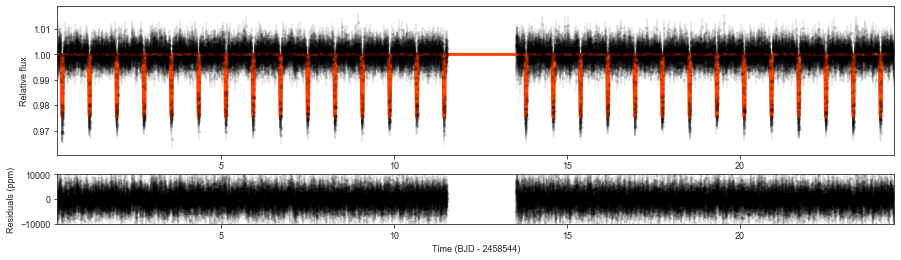

In [18]:
fig, ax = plt.subplots(2,1,figsize=(15,4),gridspec_kw={'height_ratios': [3, 1]})
# Find day of first TESS observation in Sector 9:
first_day = int(np.min(times['TESS9']))

# Plot entire lightcurve:
ax[0].errorbar(times['TESS9'] - first_day, detrended_fluxes['TESS9'], yerr = detrended_fluxes_errors['TESS9'],fmt='.', \
             color='black', alpha = 0.1)
ax[0].plot(times['TESS9'] - first_day, transit_model, color='orangered', lw=3,zorder=2)
ax[0].set_xlim(np.min(times['TESS9'] - first_day),np.max(times['TESS9'] - first_day))
#ax.set_xlabel('Time (BJD - {0:})'.format(first_day))
ax[0].set_ylabel('Relative flux')

# Plot residuals:
ax[1].errorbar(times['TESS9'] - first_day, (detrended_fluxes['TESS9']-transit_model)*1e6, \
            yerr = detrended_fluxes_errors['TESS9']*1e6,fmt='.', color='black', alpha = 0.1)
ax[1].set_xlim(np.min(times['TESS9'] - first_day),np.max(times['TESS9'] - first_day))
ax[1].set_xlabel('Time (BJD - {0:})'.format(first_day))
ax[1].set_ylim(-10000,10000)
ax[1].set_ylabel('Residuals (ppm)')

That looks nice! What about the fitted parameters? There are two options here. One is to look at some summary statistiscs; these are saved on the `out_folder` defined when we loaded the dataset, to a file called `posteriors.dat` --- let's take a look at that:

In [19]:
cat wasp19_transitfit/posteriors.dat

# Parameter Name     	 	 Median       	 	 Upper 68 CI  	 	 Lower 68 CI 
P_p1               	 	 0.7888431054 	 	 0.0000106888 	 	 0.0000100987
a_p1               	 	 3.6078820349 	 	 0.0661276234 	 	 0.0594392698
t0_p1              	 	 2458555.4546477906 	 	 0.0000948589 	 	 0.0000974610
r1_p1              	 	 0.7581160842 	 	 0.0142985787 	 	 0.0192734801
r2_p1              	 	 0.1521855950 	 	 0.0018029187 	 	 0.0023448360
p_p1               	 	 0.1521855950 	 	 0.0018029187 	 	 0.0023448360
b_p1               	 	 0.6371741263 	 	 0.0214478680 	 	 0.0289102202
inc_p1             	 	 79.8311929982 	 	 0.6144785576 	 	 0.5099892111
q1_TESS9           	 	 0.3580906336 	 	 0.2459794694 	 	 0.1479223053
q2_TESS9           	 	 0.1915836339 	 	 0.3122803636 	 	 0.1373400764
rho                	 	 1427.6874921240 	 	 79.9693162941 	 	 69.3895272854
mflux_TESS9        	 	 0.0000007164 	 	 0.0000298197 	 	 0.0000320764
sigma_w_TESS9      	 	 2.4426101947 	 	 17.9357631341 	 	 2.1309671201


The summary here is pretty self-explainatory. All the transit parameters are in excellent agreement with literature values (e.g., the values presented in [Wong et al., 2020](https://arxiv.org/abs/1912.06773)), albeit with larger errorbars to those of [Wong et al. (2020)](https://arxiv.org/abs/1912.06773). This was somewhat expected, because as mentioned in that study, the PDC lightcurve shows larger systematics than usual, which is why the authors in that study decided to do their own detrending.

How about some corner plots? Posterior distributions can be obtained through the `results.posteriors` dictionary (this is also saved as a pickle file to the `out_folder` --- in our case, `posteriors.pkl`). This dictionary, in turn, has a ton of very useful information:

In [20]:
results.posteriors.keys()

dict_keys(['lnZ', 'lnZerr', 'posterior_samples', 'pu', 'pl'])

The `lnZ` is the [bayesian evidence](https://ned.ipac.caltech.edu/level5/Sept13/Trotta/Trotta4.html) of our fit (this is one of the unique feature of Nested Samplers; this number allows you to perform proper model comparison! To use it in the context of `juliet`, see the "Excercises for the reader" at the bottom of this tutorial) --- the associated error on this is `lnZerr`. `pu` and `pl` stores the minimum and maximum planet-to-star radius ratio that we explored with the $(r_1,r_2)$ parametrization. Finally, `posterior_samples` contains the samples from the posteriors we are interested in to plot a corner plot --- that is, itself, a dictionary, containing on each key the posterior samples of each parameter:

In [21]:
results.posteriors['posterior_samples'].keys()

dict_keys(['unnamed', 'loglike', 'P_p1', 't0_p1', 'r1_p1', 'r2_p1', 'q1_TESS9', 'q2_TESS9', 'rho', 'mflux_TESS9', 'sigma_w_TESS9'])

Let's use those to get a corner plot using Dan Foreman-Mackey's `corner` library:

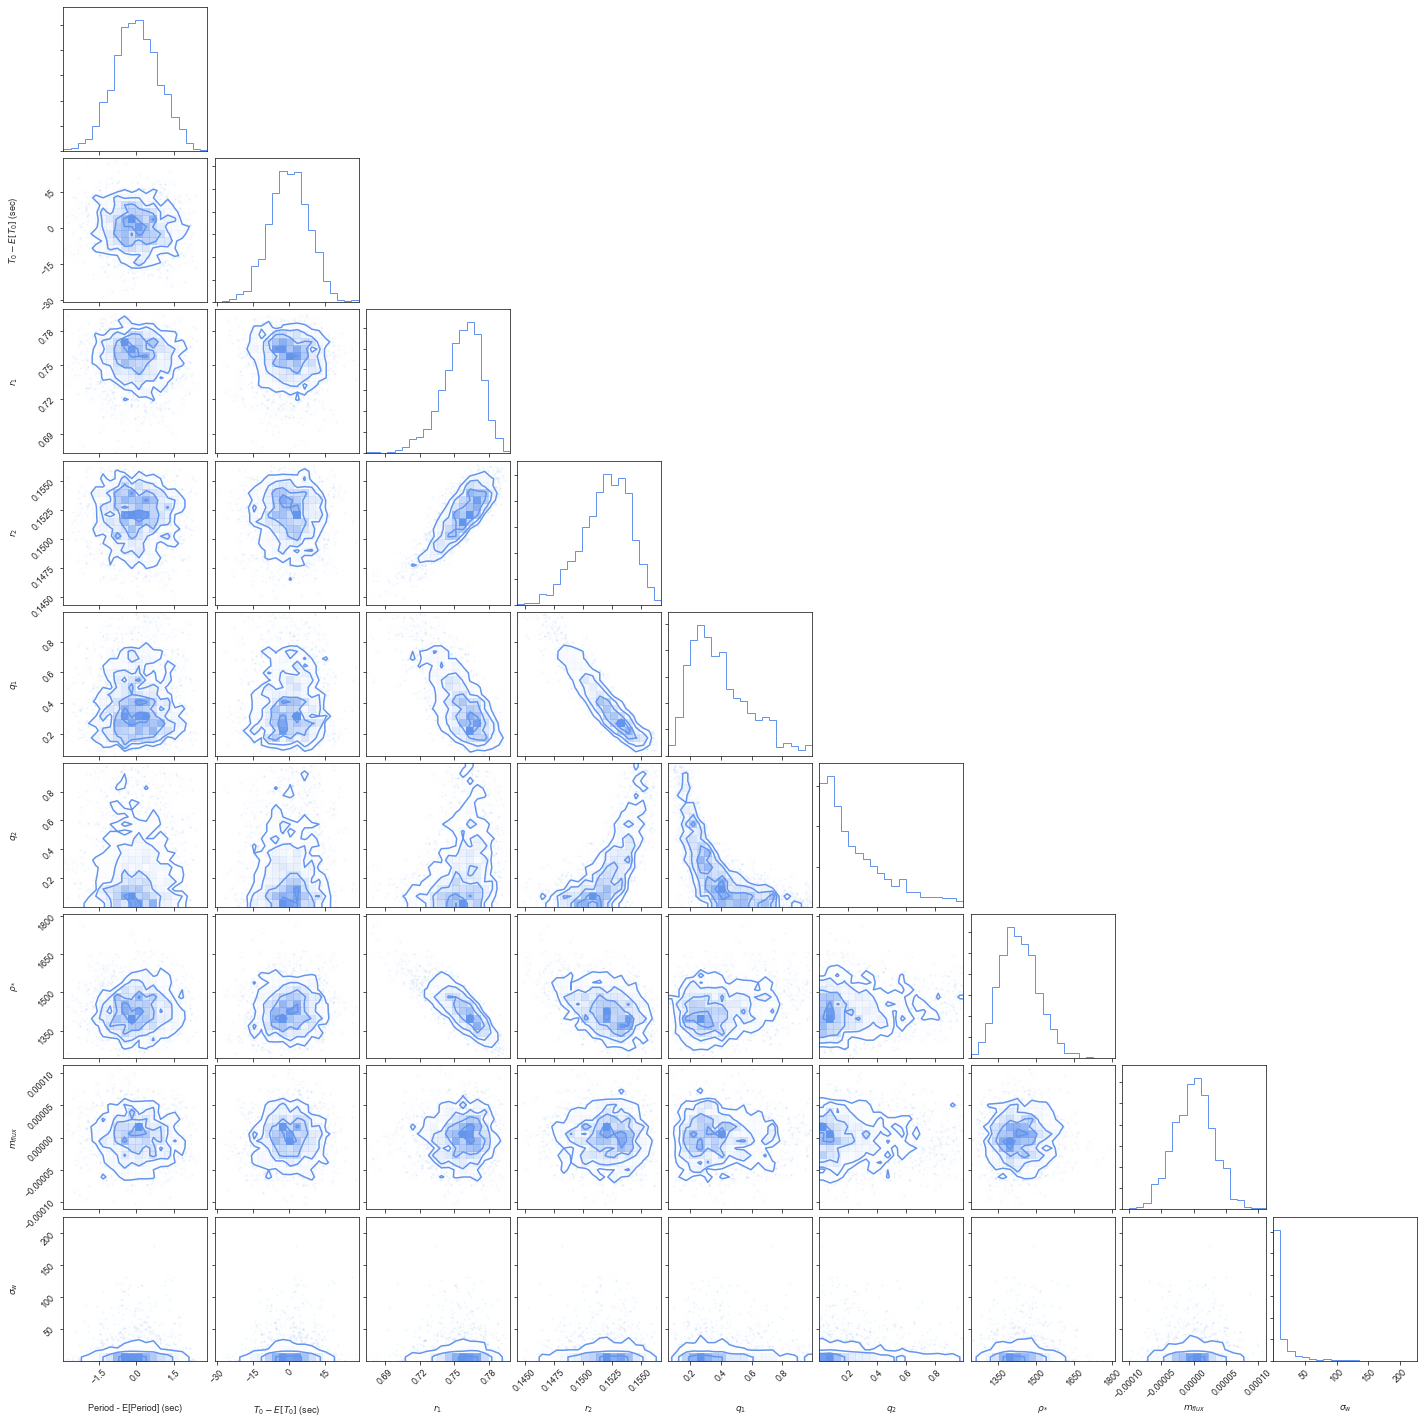

In [22]:
# Names of the parameters to show in the corner plot:
names = [r'Period - E[Period] (sec)',r'$T_0 - E[T_0]$ (sec)','$r_1$',r'$r_2$',r'$q_1$',r'$q_2$',r'$\rho_*$', '$m_{flux}$', '$\sigma_w$']

# Create a "posterior matrix":
matrix = np.zeros([len(results.posteriors['posterior_samples']['P_p1']),len(names)])
listed_keys = list(results.posteriors['posterior_samples'].keys())
for i in range(len(names)):
    if names[i] != r'$T_0 - E[T_0]$ (sec)' and names[i] != r'Period - E[Period] (sec)':
        matrix[:,i] = results.posteriors['posterior_samples'][listed_keys[i+2]]
    else:
        matrix[:,i] = (results.posteriors['posterior_samples'][listed_keys[i+2]] - \
                      np.median(results.posteriors['posterior_samples'][listed_keys[i+2]]))*24*3600

# Create corner plot:
figure = corner.corner(matrix, labels = names, color='cornflowerblue')

Pretty neat, huh? Note that the corner plot is screaming to us that we should be defining the jitter term to zero in our fit (doing this is set as an excercise to the reader!).

## 6. Modelling transits _and_ GPs with `juliet`

We can, of course, do a _joint_ fit of the GP and transits in one go. We simply **define the intersection of the priors we have defined above for both cases**:

In [23]:
# Name of the parameters to be fit:
params = ['P_p1','t0_p1','r1_p1','r2_p1','q1_TESS9','q2_TESS9','ecc_p1','omega_p1',\
              'rho', 'mdilution_TESS9', 'mflux_TESS9', 'sigma_w_TESS9', 'GP_sigma_TESS9', 'GP_rho_TESS9']

# Distribution for each of the parameters:
dists = ['normal','normal','uniform','uniform','uniform','uniform','fixed','fixed',\
                 'loguniform', 'fixed', 'normal', 'loguniform', 'loguniform', 'loguniform']

# Hyperparameters of the distributions:
hyperps = [[0.7888,0.1], [2458555.4547,0.1], [0.,1], [0.,1.], [0., 1.], [0., 1.], 0.0, 90.,\
                   [100., 10000.], 1.0, [0.,0.1], [0.1, 1000.], [0.1, 1e5], [1e-2,30]]

# Join the priors:
priors = juliet.generate_priors(params,dists,hyperps)

Now, let's **load the dataset** (note we use the original data here).

In [35]:
dataset = juliet.load(priors=priors, t_lc = times, y_lc = fluxes, \
                      yerr_lc = fluxes_errors, GP_regressors_lc = times,\
                      out_folder = 'wasp19_GPtransitfit')

And **run the fit**. Now, instead of running `juliet` as above, which by default uses `MultiNest` (via [`PyMultiNest`](https://github.com/JohannesBuchner/PyMultiNest)), let's do some variations to the previous fits:

* As a small change, let's limit the minimum and maximum planet-to-star radius ratio that the $(r_1,r_2)$ parametrization will explore --- let's set the maximum to 0.2. This is set with the `pl` (for the lower limit) and `pu` (for the upper limit) flags.

* Let's use [`dynesty`](https://dynesty.readthedocs.io/), another sampler `juliet` is able to use. This can be activated by the `use_dynesty=True` flag. 

* `dynesty` also lets us use _dynamic_ nested sampling, where the number of live points are adjusted as the run progresses (which gives rise to a more thorough sampled posterior) --- we can use that by setting the flag `dynamic=True` --- let's set this in our fit below. 

* Finally, let's do a multi-core run --- to this end, we can set the number of threads to use on our fit with the `dynesty_nthreads` flag (which we set to 4).

Let's apply all of the above using these flags (note this will take a while --- around half an hour! Dynamic nested sampler is expensive, but in the long-run and for large number of parameters, above around 20, much more efficient in exploring the parameter space even when compared to MCMC methods. Totally worth it!):

In [36]:
results = dataset.fit(use_dynesty = True, dynamic = True, dynesty_nthreads = 4, pu = 0.2)

52600it [1:16:07, 16.39it/s, batch: 3 | bound: 526 | nc: 25 | ncall: 1700974 | eff(%):  3.092 | loglstar: 68604.503 < 68611.459 < 68608.200 | logz: 68571.092 +/-    nan | stop:  0.916]      


As usual, let's evaluate the model --- but now with a slight trick: with `juliet` you can also get the _errors_ on your model (which are propagated from the posterior distributions). To do this, we simply add the `return_err = True` flag. This will return the  68\% credibility bands --- the "1-sigma" bands (these can be controlled through the `alpha` parameter. Default is `alpha=0.68`):

In [37]:
GP_plus_transit_model, upper_bound, lower_bound = results.lc.evaluate('TESS9', return_err = True)

And now let's plot all together!

Text(0, 0.5, 'Residuals (ppm)')

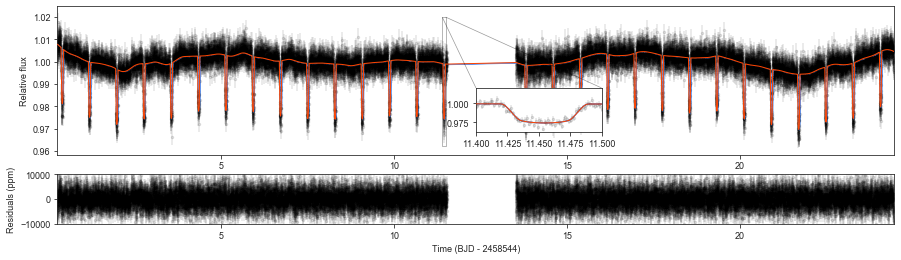

In [38]:
fig, ax = plt.subplots(2,1,figsize=(15,4),gridspec_kw={'height_ratios': [3, 1]})

# Plot entire lightcurve:
ax[0].errorbar(times['TESS9'] - first_day, fluxes['TESS9'], yerr = fluxes_errors['TESS9'],fmt='.', \
             color='black', alpha = 0.1)
# Model prediction:
ax[0].plot(times['TESS9'] - first_day, GP_plus_transit_model, color='orangered', lw=1,zorder=3)
# Plot credibility bands of model:
ax[0].fill_between(times['TESS9'] - first_day, lower_bound, \
                   upper_bound, color='cornflowerblue', zorder=2)
ax[0].set_xlim(np.min(times['TESS9'] - first_day),np.max(times['TESS9'] - first_day))
ax[0].set_ylabel('Relative flux')
# Plot inset:
axins = ax[0].inset_axes([0.5, 0.15, 0.15, 0.3])
x1, x2, y1, y2 = 11.4,11.5, 0.962, 1.02
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.errorbar(times['TESS9'] - first_day, fluxes['TESS9'], yerr = fluxes_errors['TESS9'],fmt='.', \
             color='black', alpha = 0.1)
axins.plot(times['TESS9'] - first_day, GP_plus_transit_model, color='orangered', lw=1,zorder=3)
axins.fill_between(times['TESS9'] - first_day, lower_bound, \
                   upper_bound, color='cornflowerblue', zorder=2)
mark_inset(ax[0], axins, loc1=1, loc2=2, linewidth=0.7, fc="None", ec='k', alpha=0.4, clip_on=True, zorder=3)

# Plot residuals:
ax[1].errorbar(times['TESS9'] - first_day, (fluxes['TESS9']-GP_plus_transit_model)*1e6, \
            yerr = fluxes_errors['TESS9']*1e6,fmt='.', color='black', alpha = 0.1)
ax[1].set_xlim(np.min(times['TESS9'] - first_day),np.max(times['TESS9'] - first_day))
ax[1].set_xlabel('Time (BJD - {0:})'.format(first_day))
ax[1].set_ylim(-10000,10000)
ax[1].set_ylabel('Residuals (ppm)')

Woah, the errors on the data are pretty small --- we almost can't see them, not even with the inset that we included in the figure above. Let's see what the posterior parameters look like:

In [39]:
cat wasp19_GPtransitfit/posteriors.dat

# Parameter Name     	 	 Median       	 	 Upper 68 CI  	 	 Lower 68 CI 
P_p1               	 	 0.7888432809 	 	 0.0000101898 	 	 0.0000101987
a_p1               	 	 3.6173568928 	 	 0.0775129774 	 	 0.0779272654
t0_p1              	 	 2458555.4546461725 	 	 0.0000947071 	 	 0.0000942610
r1_p1              	 	 0.6682539830 	 	 0.0233326015 	 	 0.0276132877
r2_p1              	 	 0.7646785081 	 	 0.0260407825 	 	 0.0255905586
p_p1               	 	 0.1529357016 	 	 0.0052081565 	 	 0.0051181117
b_p1               	 	 0.6350793813 	 	 0.0256658616 	 	 0.0303746165
inc_p1             	 	 79.8923677274 	 	 0.6728758064 	 	 0.6296064859
q1_TESS9           	 	 0.3461020351 	 	 0.2108723649 	 	 0.1367098352
q2_TESS9           	 	 0.2008088327 	 	 0.2947919298 	 	 0.1378195731
rho                	 	 1438.9422035550 	 	 94.4912035966 	 	 91.0148345846
mflux_TESS9        	 	 0.0128365635 	 	 0.0701946495 	 	 0.0689725229
sigma_w_TESS9      	 	 2.2623732941 	 	 17.5649814634 	 	 1.9534240878
GP_si

Although our results are consistent with those found in our sequential method (i.e., the one where we detrended first and _then_ fitted the transits), note that the errorbars are larger (e.g., for the transit depth). This illustrates how important it is, in general, to perform detrending _together_ with the transit fitting --- a quick detrending plus transit fit is okay for overall checks, but the final to-be-reported fit needs to include all components simulatenously, especially in cases like this in which many transits are distributed all along the dataset.

## 7. Excercises for the reader

1. **We didn't check if the GP model we used is the optimal one to use in our case.** Go back to Section 4.2 and use [the different GPs one is able to use with `juliet`](https://juliet.readthedocs.io/en/latest/user/priorsnparameters.html#exoplanets-with-juliet-pt-iii-linear-models-gaussian-processes) to check which is the best model. To this end, use the bayesian evidences `lnZ` available via either the `results.posteriors` dictionary, or reading the `posteriors.pkl` file (`posteriors = pickle.load(open('posteriors.pkl','rb'))`). If all GP models are equally likely a-priori, `exp(lnZ1 - lnZ2)` will give you how much more likely model 1 with `lnZ1` is over model 2 with `lnZ2` given the data. Try a celerite exponential-matern and a celerite quasi-periodic kernel along with the pure Matern kernel we tried in our example.


2. **How much do the fit done in Section 5 changes if we don't fit for a `sigma_w_TESS9`?** Set it to zero, run a fit and compare how that fit does with the one done in that section. Does the bayesian evidence support dropping this jitter term in that fit?


3. **Try using the parametrization of `p` and `b` directly instead of `r1_p1` and `r2_p1` in any of our fits** --- do you get the same results?


4. **In Section 4.2 we tried a GP to detrend the data --- what if you use other methods (e.g., a median filter)?** Does one get consistent results?